This notebook contains SOTIP's spatial domain identification module using a osmFISH cortex dataset, and is a reproduce of original paper figure 3e-h. For the steps, please refer to the table of contents automatically generated by jupyterlab on the left side bar.

author: Zhiyuan Yuan

# imports

In [1]:
from sotip import *
import numpy as np
import scanpy as sc


# data loading and processing steps

### load osmFISH cortex data

In [2]:
# this data is derived from the original osmFISH nature methods paper
# please refer to our supplementary table 1 for more data details
adata = sc.read_h5ad('data/cortex_paper.h5ad')

### process the data with scanpy routine

In [3]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


### infer moderate clustering resolution

In [4]:
target_num = np.unique(adata.obs['ClusterName']).shape[0]
res_recom = search_res(adata, target_num, start=1, step=0.1, tol=5e-3, max_run=10)

Start at res =  1 step =  0.1
Res =  1 Num of clusters =  18
Res =  1.1 Num of clusters =  19
Res changed to 1.1
Res =  1.2000000000000002 Num of clusters =  21
Res changed to 1.2000000000000002
Res =  1.3000000000000003 Num of clusters =  22
Res changed to 1.3000000000000003
Res =  1.4000000000000004 Num of clusters =  23
Res changed to 1.4000000000000004
Res =  1.5000000000000004 Num of clusters =  25
Res changed to 1.5000000000000004
Res =  1.6000000000000005 Num of clusters =  26
Res changed to 1.6000000000000005
Res =  1.7000000000000006 Num of clusters =  26
Res changed to 1.7000000000000006
Res =  1.8000000000000007 Num of clusters =  27
Res changed to 1.8000000000000007
Res =  1.9000000000000008 Num of clusters =  28
Res changed to 1.9000000000000008
Res =  2.000000000000001 Num of clusters =  30
Res changed to 2.000000000000001
Res =  2.100000000000001 Num of clusters =  33
Step changed to 0.05
Res =  2.0500000000000007 Num of clusters =  32
recommended res =  2.05000000000000

### perform single cell clustering

In [5]:
sc.tl.leiden(adata,resolution=res_recom)

### plot clustering result

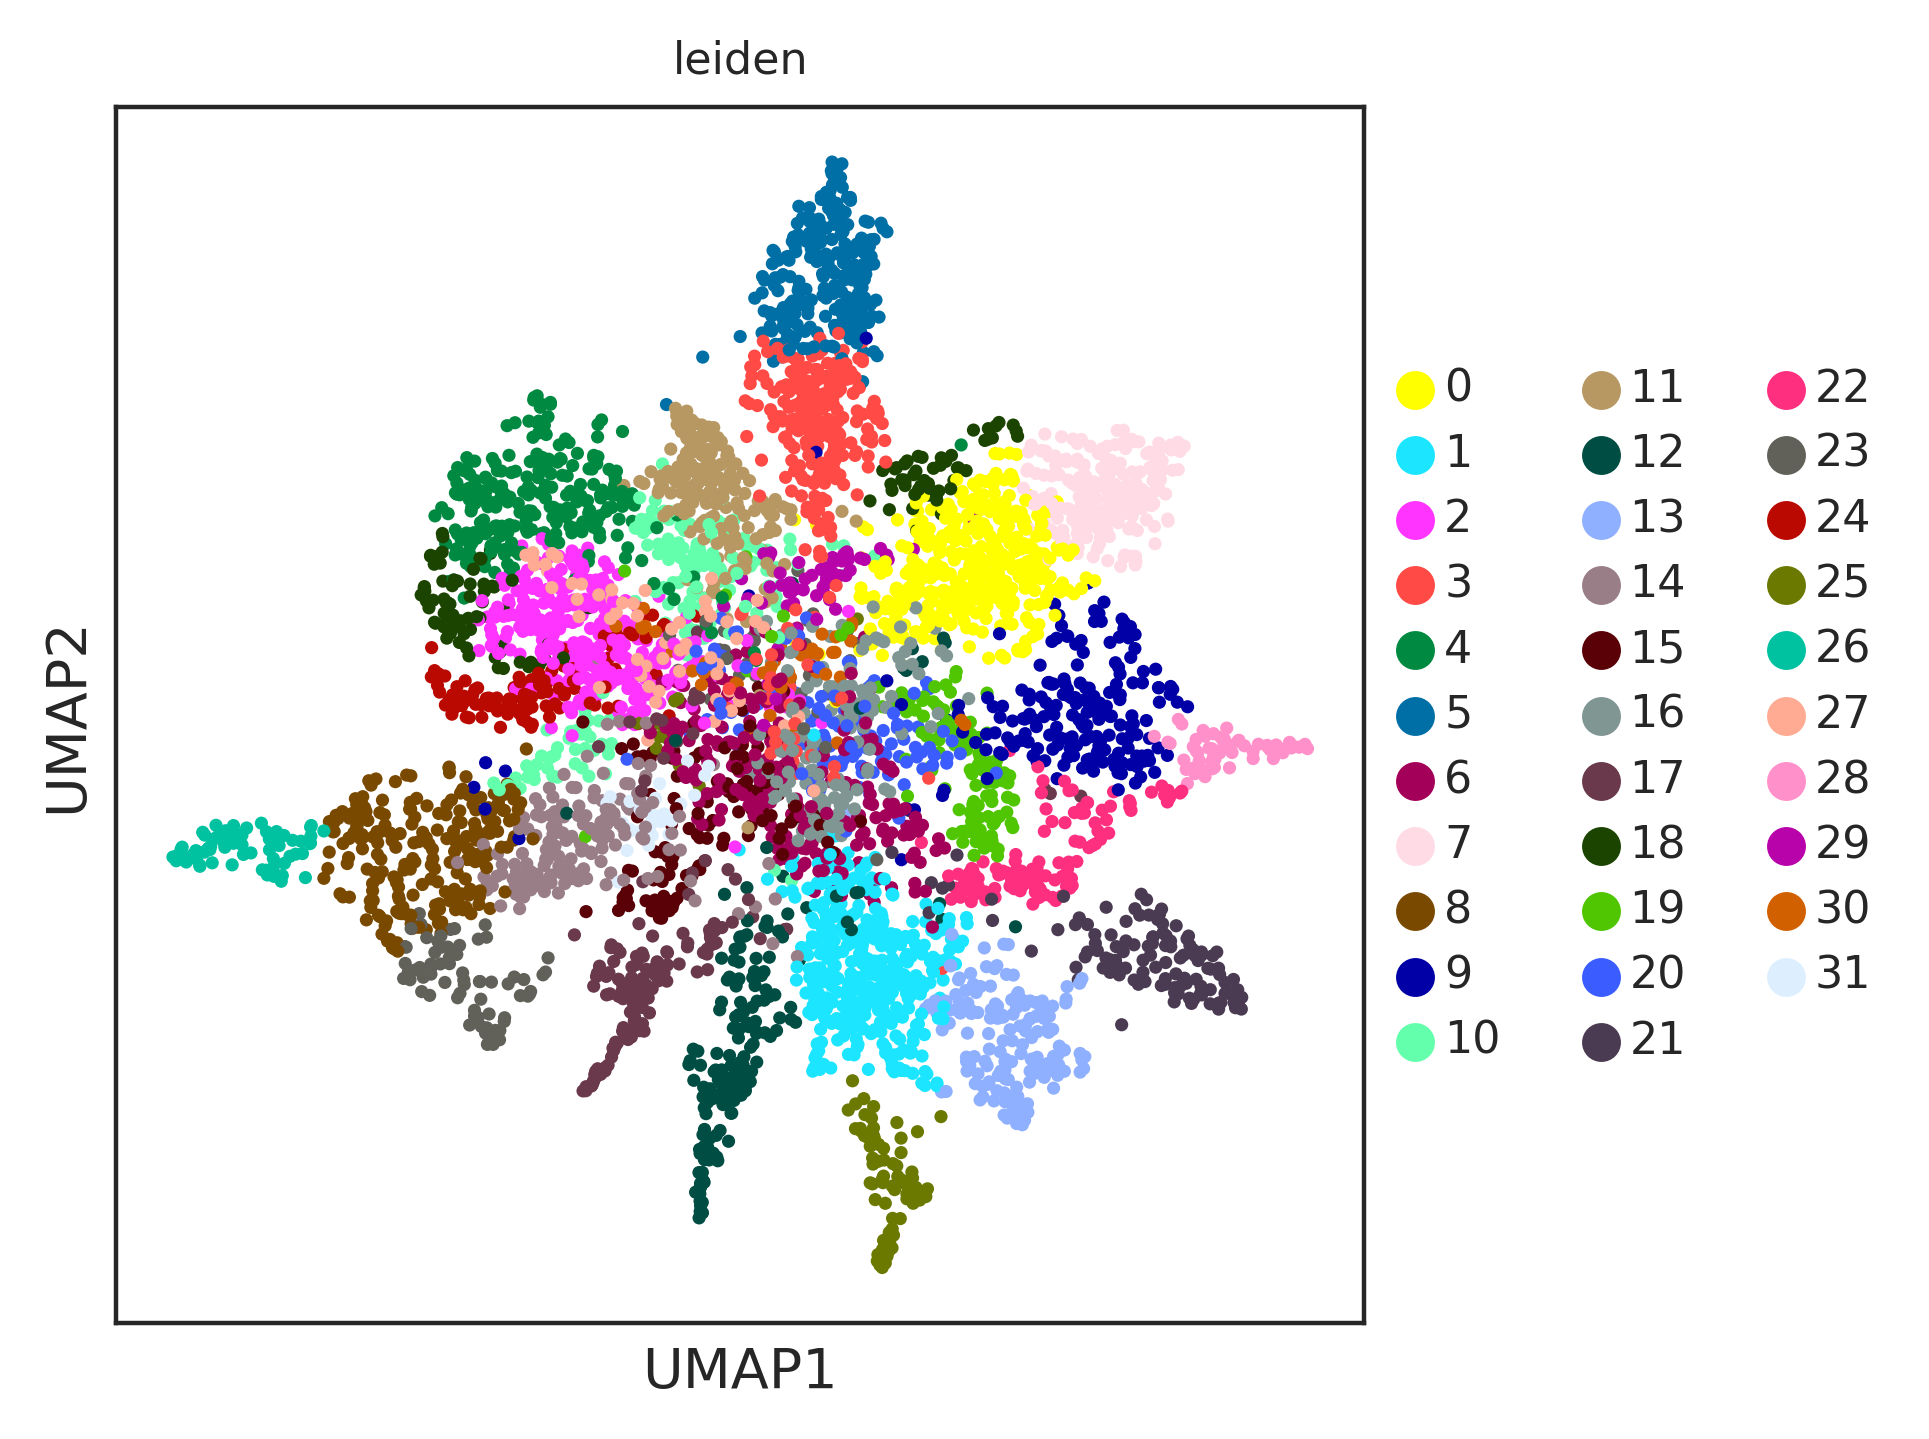

In [8]:
sc.pl.umap(adata,color=['leiden'])

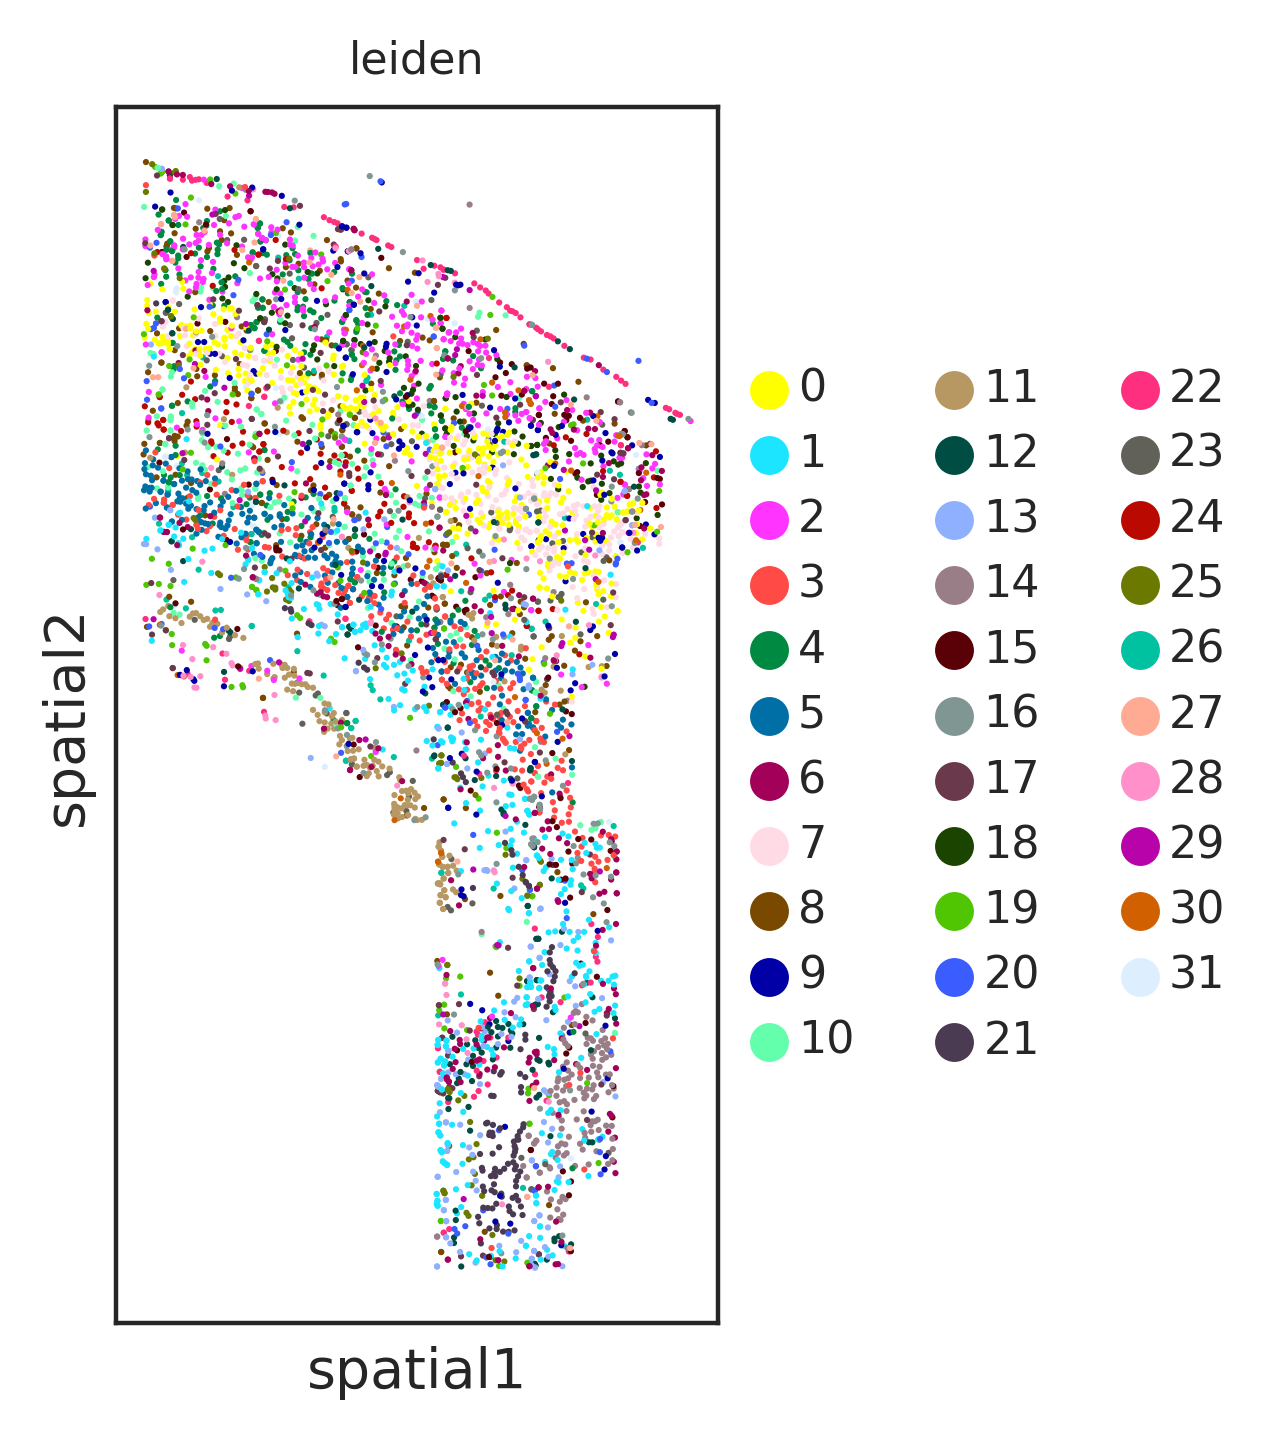

In [9]:
sc.pl.embedding(adata,basis='spatial',color=['leiden'],show=False,size=5,marker='.')
plt.gca().set_aspect('equal', adjustable='box') 


# SOTIP steps

### step 1: each ME is associated with its center cell

In [10]:
# ME size 
knn = 10

# spatial coordination used for ME
spatial_var='spatial'

# cluster label used for ME
cls_key='leiden'

# order of cluster label for ME representation (adata.obsm['ME'])
ME_var_names_np_unique = np.array(adata.obs[cls_key].cat.categories) 

# this function added a ME obsm for adata
MED(adata,use_cls=cls_key,nn=knn,copy=False,ME_var_names_np_unique=ME_var_names_np_unique,spatial_var=spatial_var) 


knn search time cost 0.012477397918701172 s
0 MEs,time cost 1.9073486328125e-06 s, 5328 MEs, 1.0162353515625e-05s left
1000 MEs,time cost 0.1566910743713379 s, 4328 MEs, 0.6781589698791504s left
2000 MEs,time cost 0.17472290992736816 s, 3328 MEs, 0.5814778442382813s left
3000 MEs,time cost 0.17461943626403809 s, 2328 MEs, 0.4065140476226807s left
4000 MEs,time cost 0.1545255184173584 s, 1328 MEs, 0.20520988845825194s left
5000 MEs,time cost 0.17647242546081543 s, 328 MEs, 0.05788295555114746s left


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [13]:
# the resulted ME representation is a n*k vector
# n is the number of MEs (cells), k is the number of unique cell clusters
# the i,jth element of the representation is defined as the frequency of cell type_j in ME_i
adata.obsm['ME'].shape

(5328, 32)

### step 2: Connectivity guided minimum graph distance (CGMGD)

#### step 2.1 topological structure is computed with paga

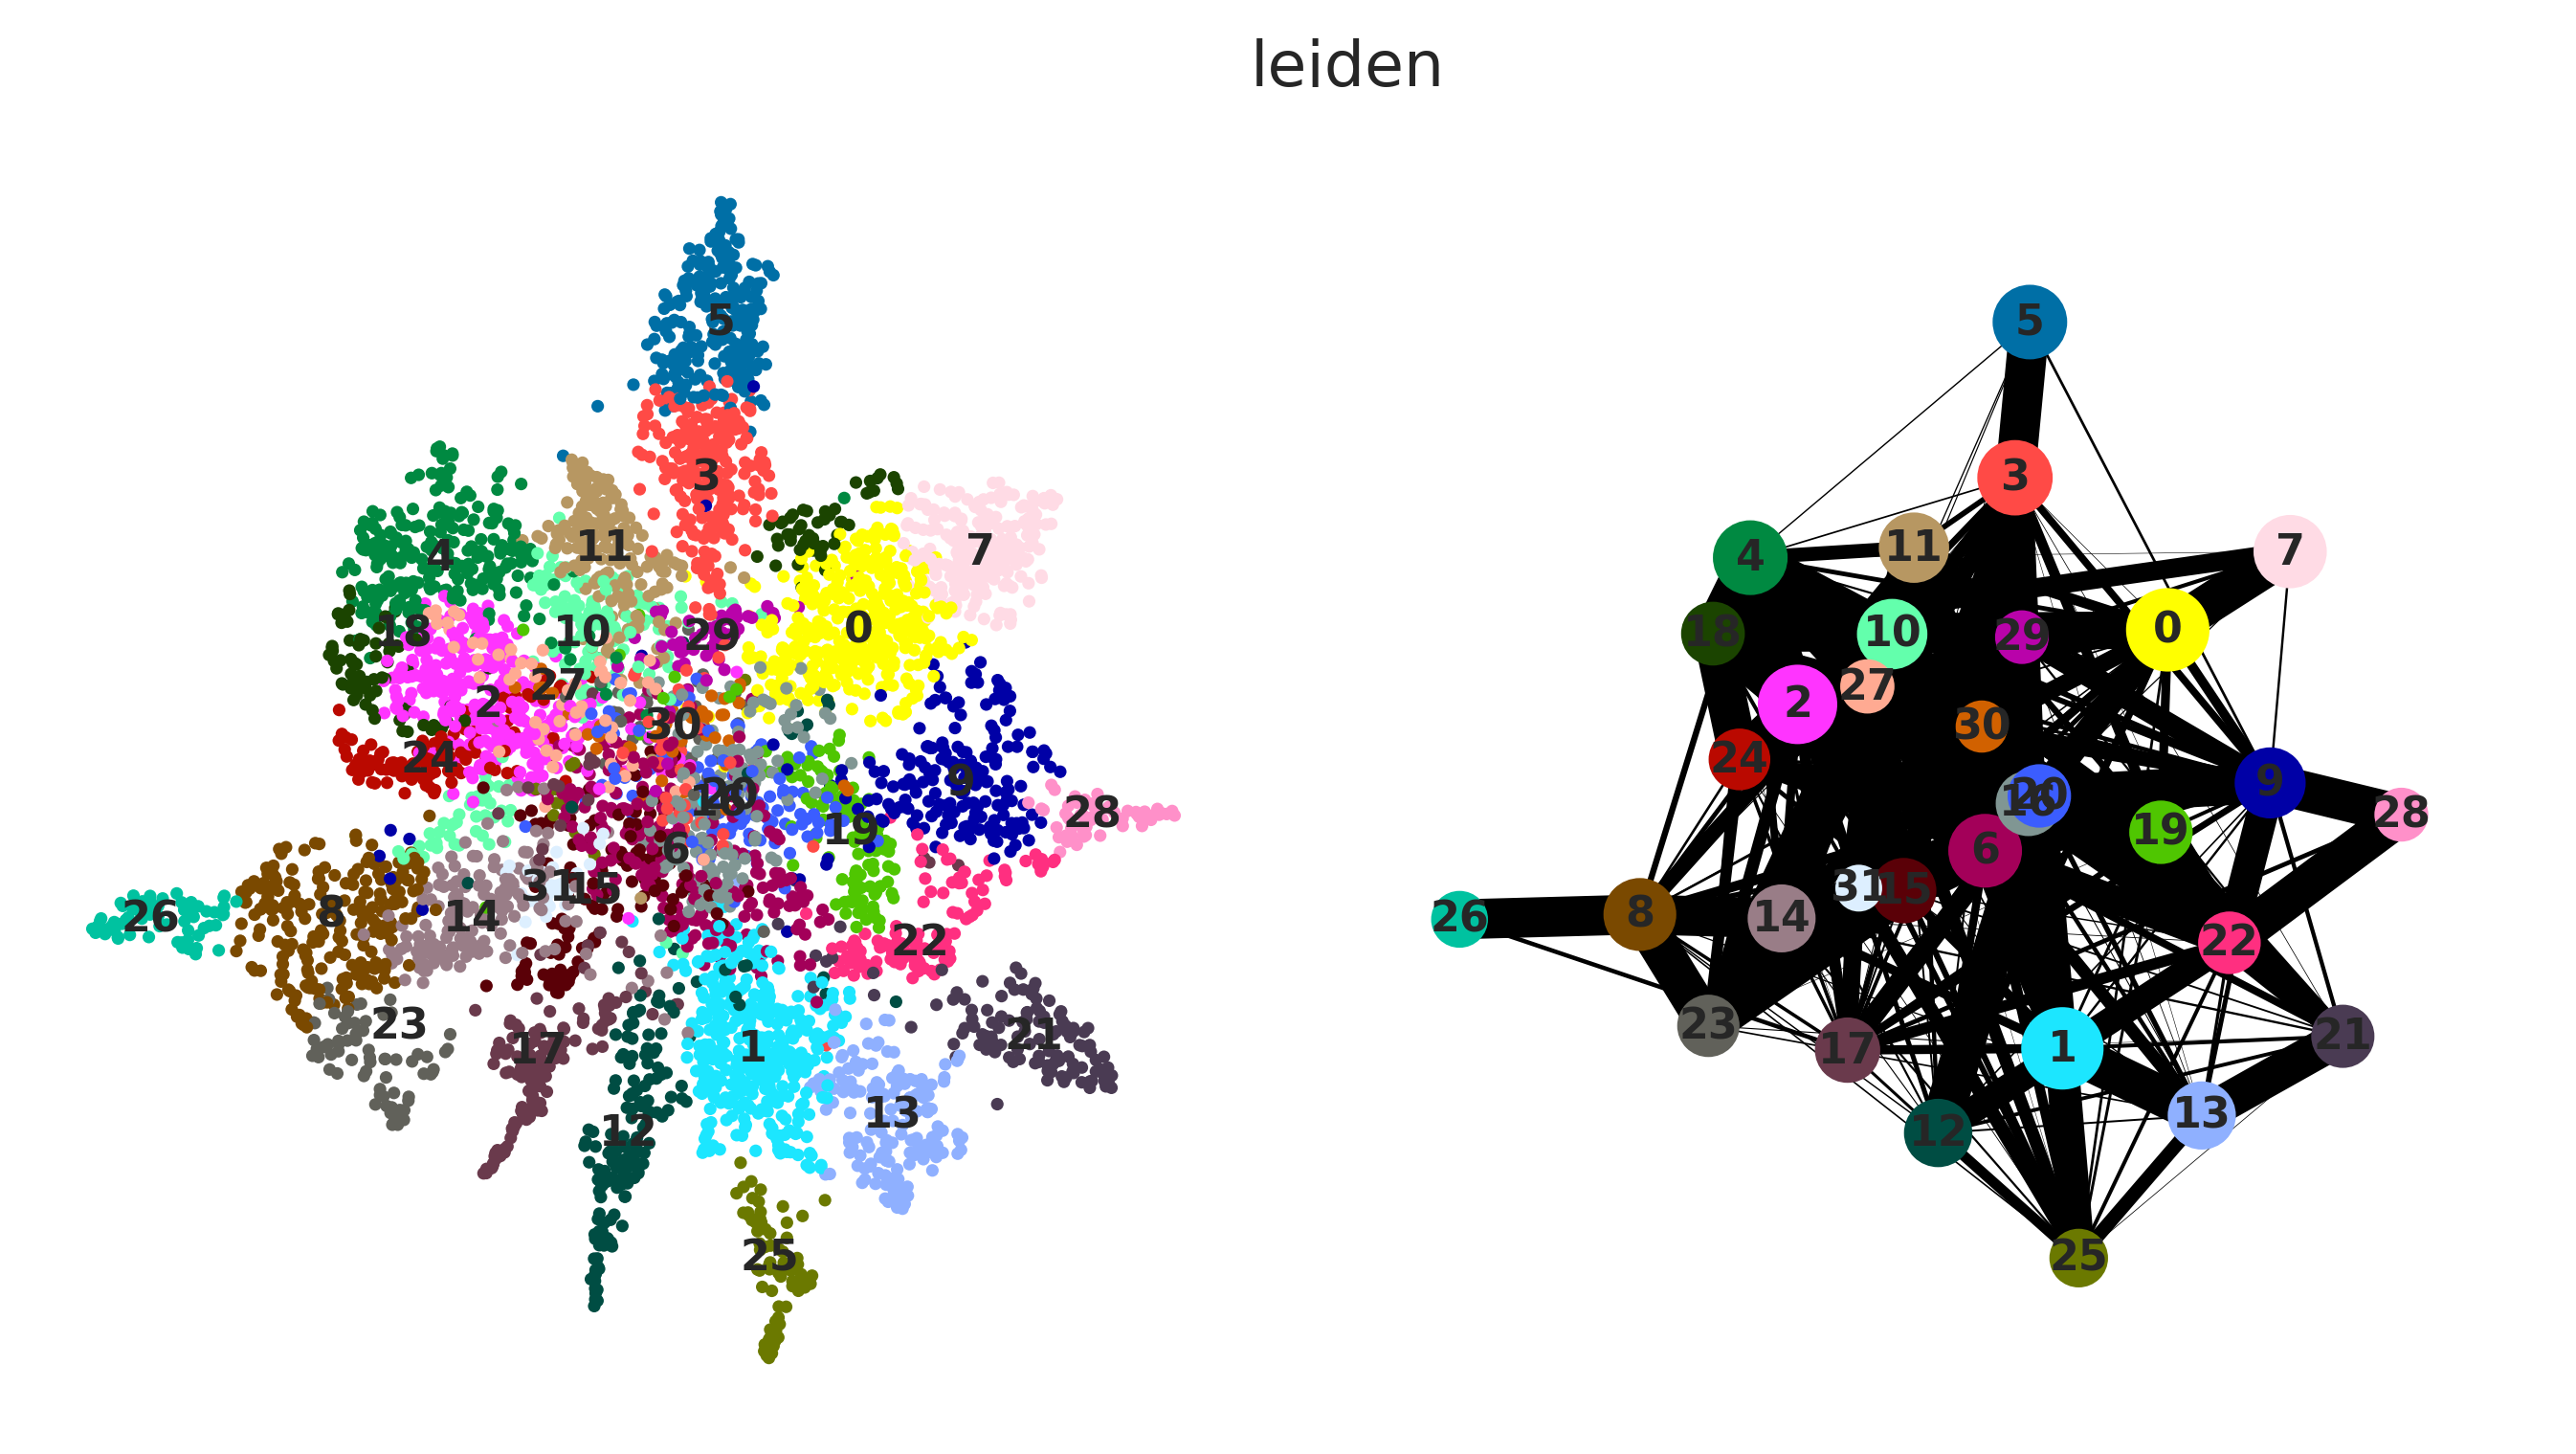

In [15]:
cls_key = 'leiden'
sc.tl.paga(adata,groups=cls_key)
sc.pl.paga_compare(adata,basis='X_umap')

#### step 2.2 the connectivities between cell clusters is used to guide the graph distance computation

In [16]:
gd_method = 'paga_guided_umap'
gd = get_ground_distance(adata,method=gd_method,cls_key=cls_key)  


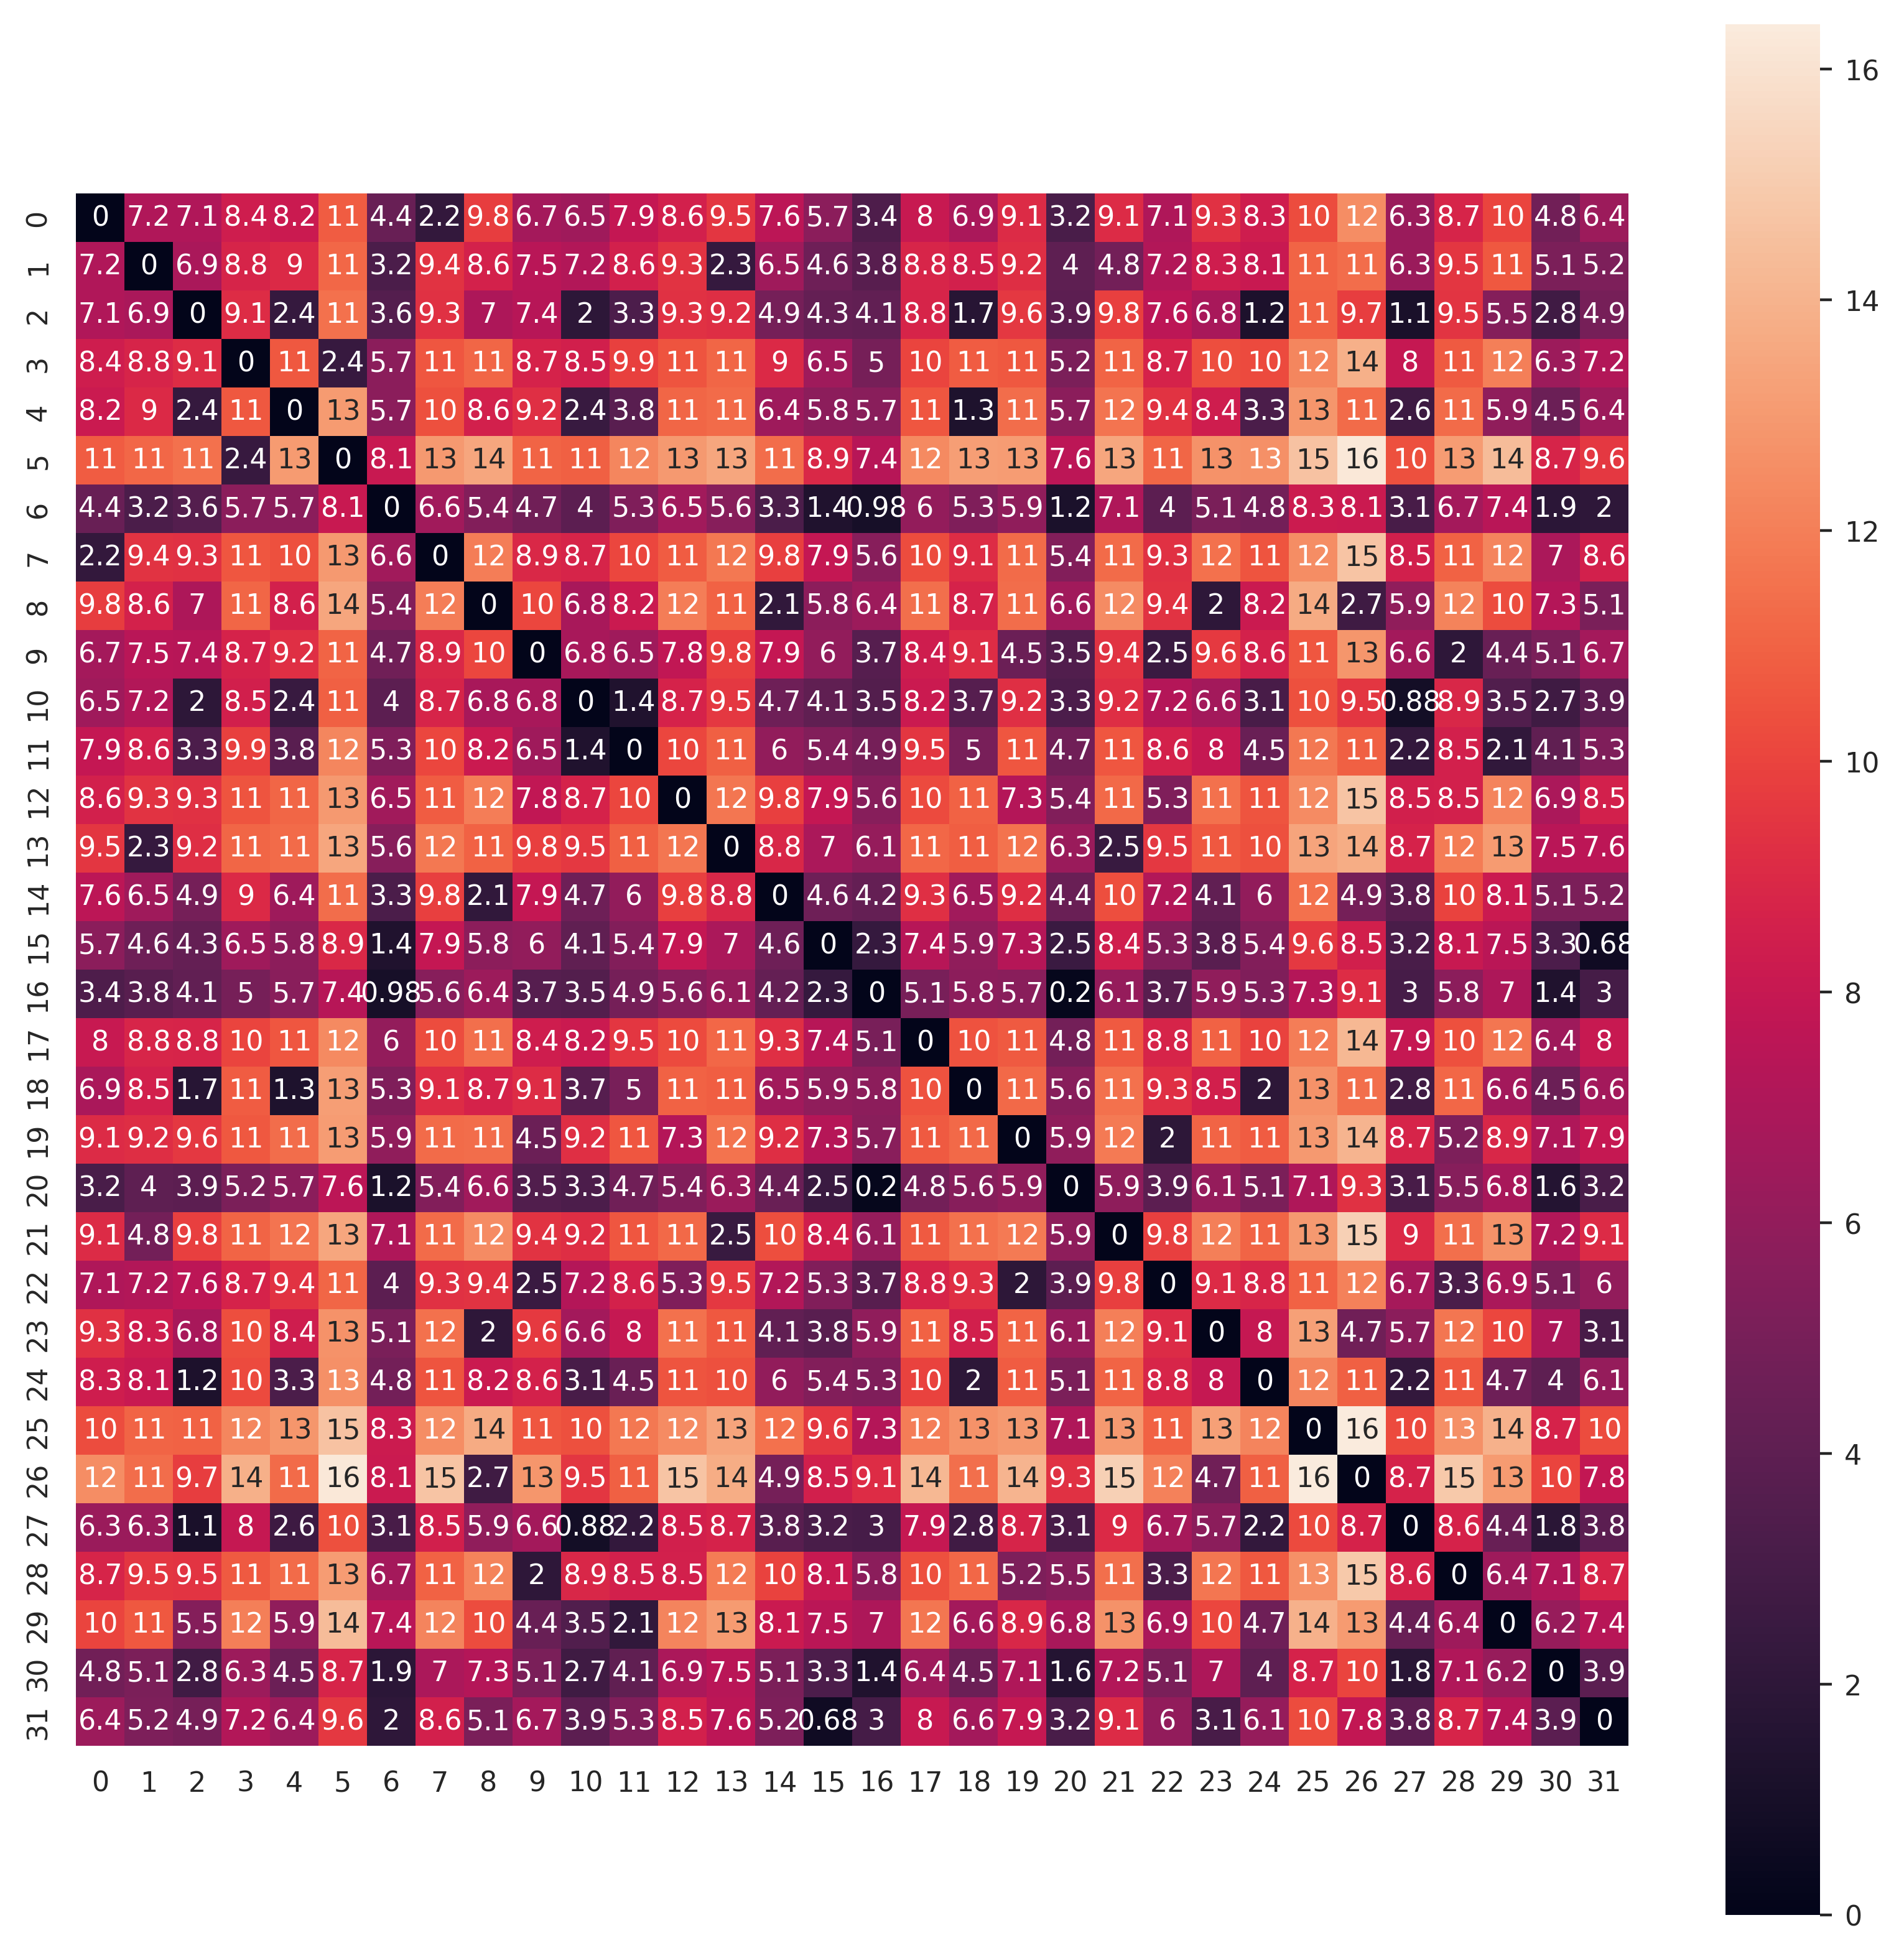

In [17]:
# plot the CGMGD
plot_matrix(gd)

### step 3 compute pairwise ME distance

In [18]:
# this step will add a X_ME_EMD_mat obsm to adata_phEMD
adata_phEMD = MED_phEMD_mp(
    adata.copy(),         # the used anndata
    GD_method=gd_method,  # use CGMGD as ground distance
    MED_knn=knn,          # ME size is set consistently as 10
    CT_obs=cls_key,       # use leiden cluster label
    ifspatialplot=False,  # do not show intermediate result plot
    OT_method='pyemd',    # use pyemd to compute EMD as ME distance
    ME_precompyted=True,  # use precomputed ME representation (already computed in step 1)
    GD_precomputed=True,  # use precomputed ground distance (already computed in step 2)
    mp=200                # multi process to accelerate the computation
)

EMD distance matrix cost 239.35934901237488s


In [19]:
# emd_distmat is the n*n pairwise ME distance
emd_distmat = (adata_phEMD.obsm['X_ME_EMD_mat'])
emd_distmat.shape

(5328, 5328)

### step 4 construct ME graph

In [20]:
# emd_distmat is computed by step 3
adata.obsp['ME_EMD_mat'] = emd_distmat

# number of neighbors is set to construct ME graph
n_neighbors=500

# compute the MEG, each node is a ME, edge is the connectivity. use similar manner as scanpy
sc.pp.neighbors( adata, n_neighbors=n_neighbors)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap( emd_distmat, n_neighbors=n_neighbors, metric='precomputed' )
adata.obsp['distances'], adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    adata.shape[0],
    n_neighbors, # change to neighbors you plan to use
)

# set the ME graph's associated information (connectivity matrix, distance matrix) to neighbors_EMD
adata.uns['neighbors_EMD'] = adata.uns['neighbors'].copy()

### step 5 spatial domain identification

#### step 5.1 use computed MEG as input of umap and leiden clustering

In [21]:
sc.tl.umap(adata,neighbors_key='neighbors_EMD')
adata.obsm['X_umap_EMD'] = adata.obsm['X_umap']
sc.tl.leiden(adata,neighbors_key='neighbors_EMD',key_added='leiden_EMD')

#### step 5.2 ME plotted with umap

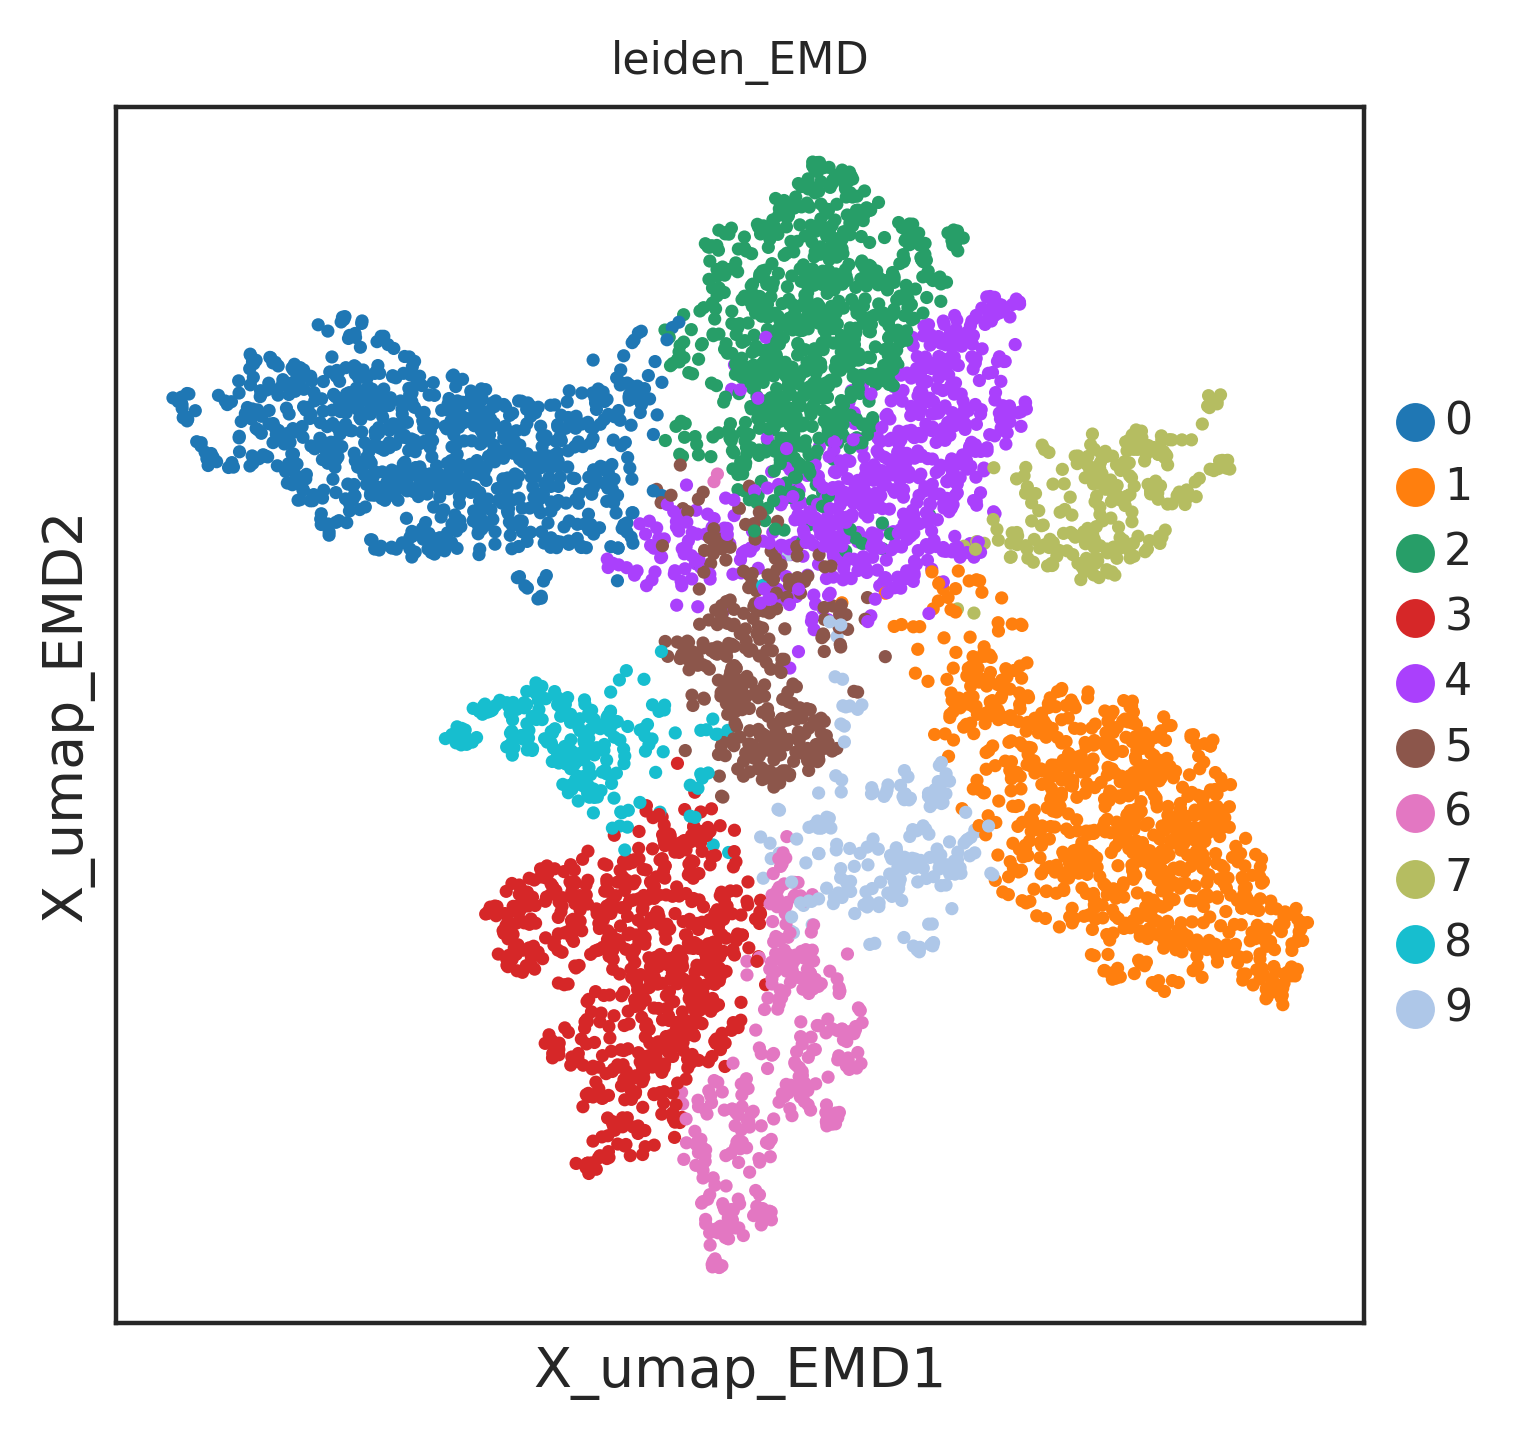

In [22]:
sc.pl.embedding(adata,basis='X_umap_EMD',color='leiden_EMD')

#### step 5.3 plot spatial domain

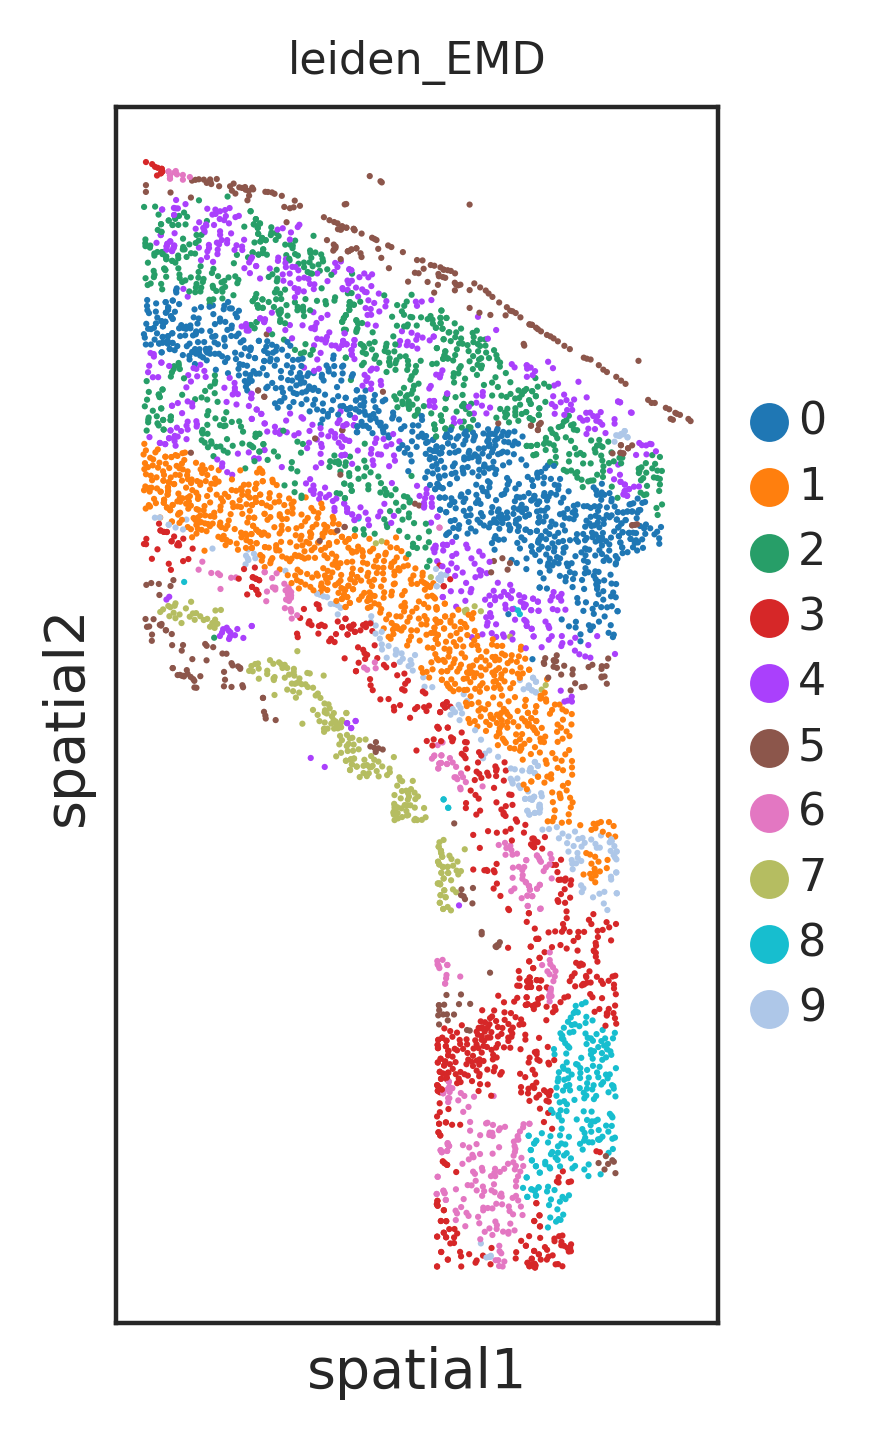

In [22]:
sc.pl.embedding(adata,basis='spatial',color=['leiden_EMD'],show=False,size=5,marker='.')
plt.gca().set_aspect('equal', adjustable='box') 


#### step 5.4 ground truth region label

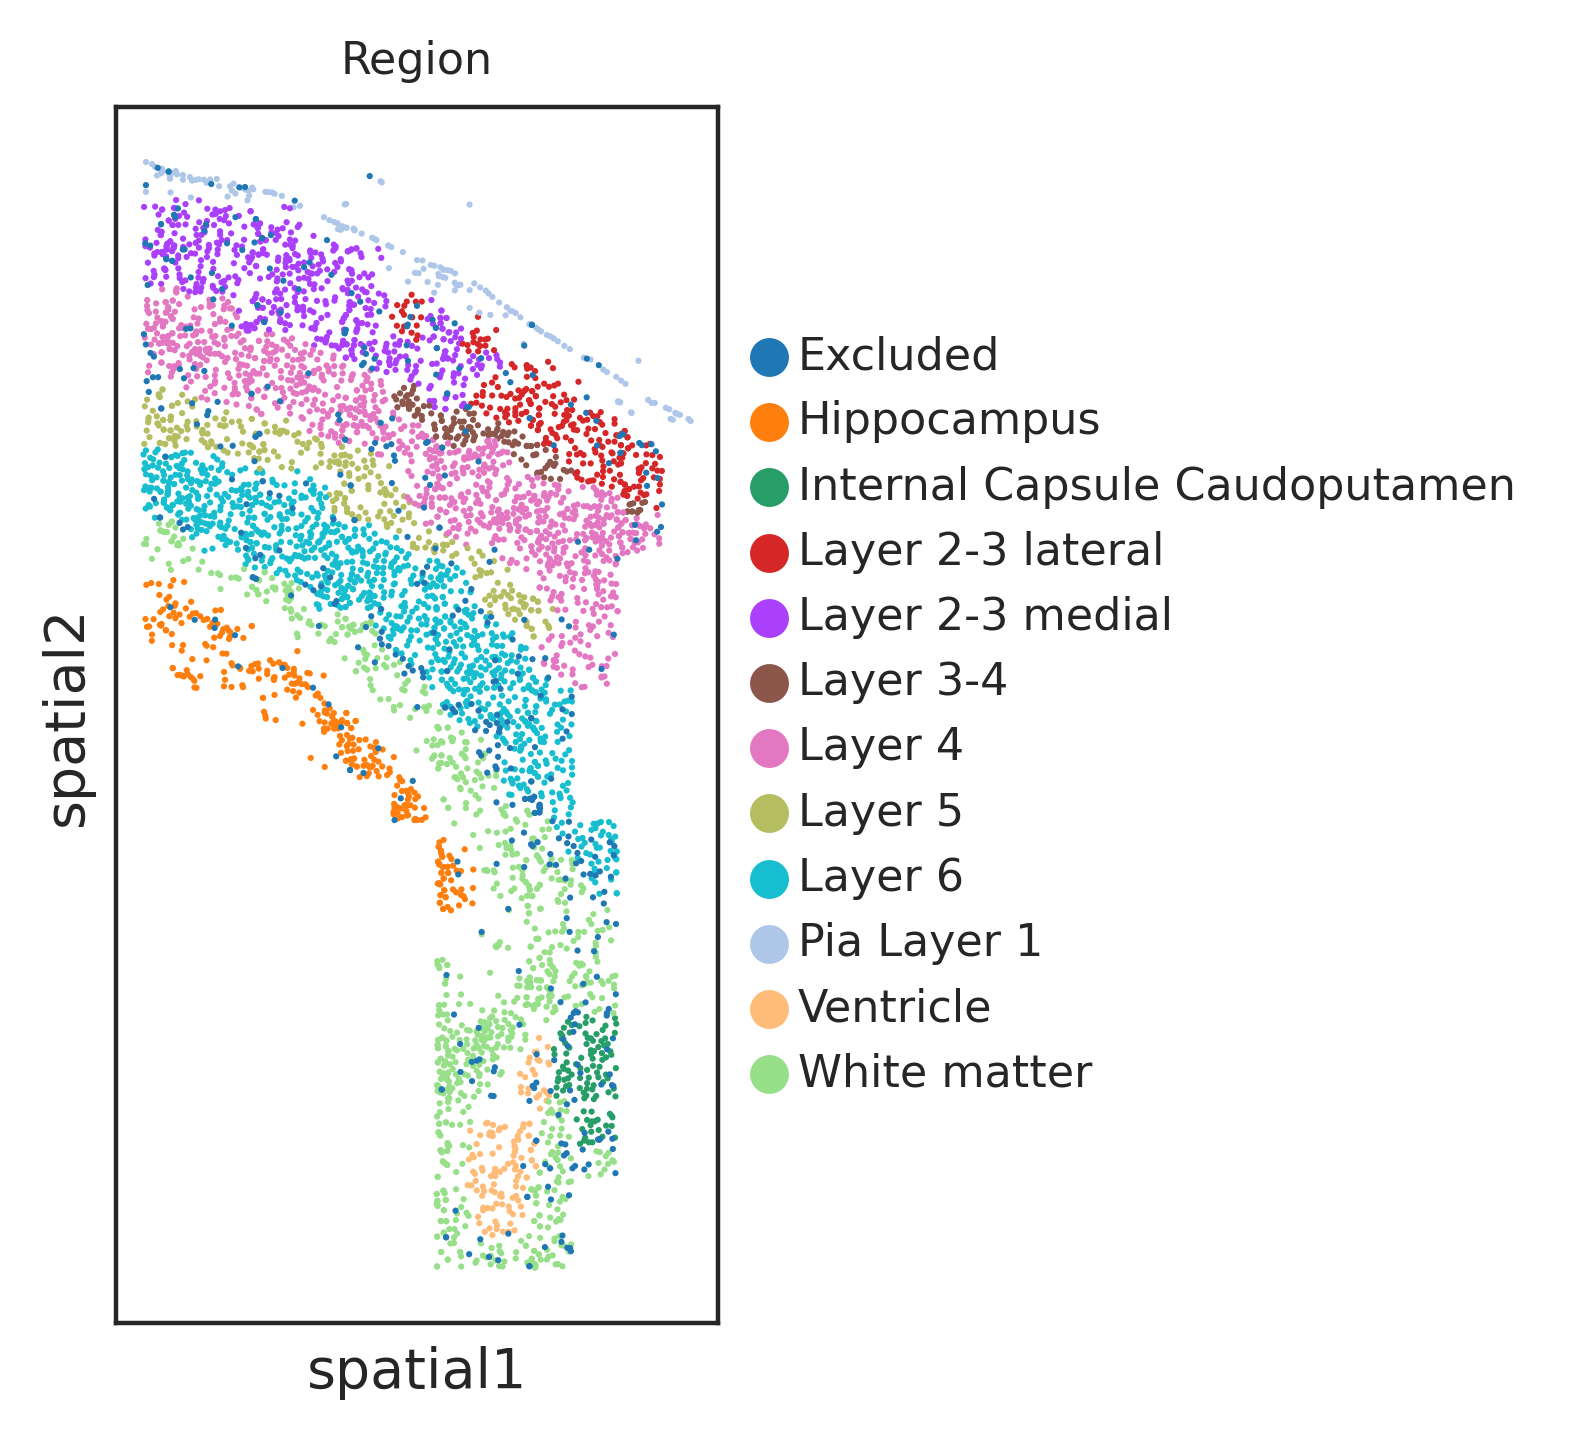

In [23]:
sc.pl.embedding(adata,basis='spatial',color=['Region'],show=False,size=5,marker='.')
plt.gca().set_aspect('equal', adjustable='box') 


#### step 5.5 ARI 

In [24]:
# we remove the "Excluded" part
adata_valid = adata[adata.obs['Region']!='Excluded']
cur_ari = adjusted_rand_score(adata_valid.obs['leiden_EMD'],adata_valid.obs['Region'])
cur_ari

0.5660977465949869